In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.datasets import VOCDetection
import torchvision.transforms as T
from PIL import Image

class VOCDataset(Dataset):
    def __init__(self, root: str, year: str = '2007', image_set: str = 'train', download: bool = True, transform: T.Compose = None):
        self.transform = transform
        self.dataset = VOCDetection(root=root, year=year, image_set=image_set, download=download)
        self.classes = [
            'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
            'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
            'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
        ]

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        img, annotation = self.dataset[idx]

        if self.transform:
            img = self.transform(img)

        width = int(annotation['annotation']['size']['width'])
        height = int(annotation['annotation']['size']['height'])

        label = torch.zeros((S, S, B * 5 + C))

        objects = annotation['annotation']['object']

        # Convert single object to list
        if isinstance(objects, dict):
            objects = [objects]

        cell_tracker = {}  # To track the number of boxes per grid cell

        for obj in objects:
            class_name = obj['name']
            class_idx = self.classes.index(class_name)

            bbox = obj['bndbox']
            xmin = int(bbox['xmin'])
            xmax = int(bbox['xmax'])
            ymin = int(bbox['ymin'])
            ymax = int(bbox['ymax'])

            # Convert bbox to YOLO format
            x_center = (xmin + xmax) / 2.0 / width
            y_center = (ymin + ymax) / 2.0 / height
            bbox_width = (xmax - xmin) / width
            bbox_height = (ymax - ymin) / height

            # Find grid cell (i, j)
            i = int(S * y_center)
            j = int(S * x_center)

            # Track bounding boxes per grid cell
            if (i, j) not in cell_tracker:
                cell_tracker[(i, j)] = 0

            box_idx = cell_tracker[(i, j)]

            if box_idx < B:
                start_idx = box_idx * 5
                label[i, j, start_idx:start_idx+5] = torch.tensor([x_center, y_center, bbox_width, bbox_height, 1])
                label[i, j, B * 5 + class_idx] = 1

                cell_tracker[(i, j)] += 1

        return img, label

In [2]:
architecture = [
    ("conv", [32, 3, 1, 1]),    # Initial stem conv
    ("conv", [64, 3, 2, 1]),    # Downsample (Stride=2)
    ("conv", [64, 1, 1, 0]),
    ("conv", [128, 3, 1, 1]),
    ("maxpool", [2, 2]),        # Reduce spatial dims

    # CSP Block (Inspired by CSPDarknet)
    ("conv", [64, 1, 1, 0]),
    ("conv", [128, 3, 1, 1]),
    ("conv", [64, 1, 1, 0]),
    ("conv", [128, 3, 1, 1]),

    ("maxpool", [2, 2]),

    ("conv", [128, 1, 1, 0]),
    ("conv", [256, 3, 1, 1]),
    ("conv", [128, 1, 1, 0]),
    ("conv", [256, 3, 1, 1]),

    ("maxpool", [2, 2]),

    ("conv", [256, 1, 1, 0]),
    ("conv", [512, 3, 1, 1]),
    ("conv", [256, 1, 1, 0]),
    ("conv", [512, 3, 1, 1]),

    ("maxpool", [2, 2]),

    ("conv", [512, 1, 1, 0]),
    ("conv", [1024, 3, 1, 1]),
    ("conv", [512, 1, 1, 0]),
    ("conv", [1024, 3, 1, 1]),

    # Spatial Pyramid Pooling (SPP) to enhance receptive field
    ("conv", [512, 1, 1, 0]),
    ("conv", [1024, 3, 1, 1]),
    ("conv", [512, 1, 1, 0]),
    ("conv", [1024, 3, 1, 1]),

    # Extra Downsample with stride=2 conv
    ("conv", [1024, 3, 2, 1]),

    ("conv", [1024, 3, 1, 1]),
    ("conv", [1024, 3, 1, 1]),
]

BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 1e-5
BETAS = (0.9, 0.99)
EPOCHS = 50
S = 7
B = 2
C = 20
IMAGE_SIZE = 448

aug = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformation = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
import torch.nn as nn
import torch

class YoloLoss(nn.Module):
    def __init__(self, lambda_coord=5, lambda_noobj=0.5, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.S = S
        self.B = B
        self.C = C

        self.mse = nn.MSELoss(reduction="mean")
        self.ce = nn.CrossEntropyLoss()

    def forward(self, pred: torch.Tensor, gt: torch.Tensor) -> torch.Tensor:
        """
        Computes the YOLOv1 loss function.

        Args:
            pred (torch.Tensor): Model predictions with shape (batch_size, S, S, B*5 + C).
            gt (torch.Tensor): Ground truth labels with shape (batch_size, S, S, B*5 + C).

        Returns:
            torch.Tensor: Total loss (localization + confidence + classification).
        """
        batch_size = pred.shape[0]

        pred = pred.view(batch_size, self.S, self.S, (self.B * 5 + self.C))
        gt = gt.view(batch_size, self.S, self.S, (self.B * 5 + self.C))

        pred_boxes = pred[..., :self.B * 5].view(batch_size, self.S, self.S, self.B, 5)
        pred_class = pred[..., self.B * 5:]

        gt_boxes = gt[..., :self.B * 5].view(batch_size, self.S, self.S, self.B, 5)
        gt_confidence = gt[..., 4:6].view(batch_size, self.S, self.S, self.B)
        gt_class = gt[..., self.B * 5:]

        # Compute IoU for all B boxes
        ious = IOU(pred_boxes[..., :4], gt_boxes[..., :4])
        best_box_idx = torch.argmax(ious, dim=-1, keepdim=True)

        # Mask for responsible bounding box
        obj_mask = torch.zeros_like(pred_boxes[..., 0], dtype=torch.bool)
        obj_mask.scatter_(-1, best_box_idx, (gt_confidence > 0))

        # Mask for cells with no objects
        noobj_mask = ~obj_mask

        # Localization loss (only for responsible boxes)
        xy_loss = self.mse(
            pred_boxes[..., :2][obj_mask],
            gt_boxes[..., :2][obj_mask]
        )
        wh_loss = self.mse(
            torch.sqrt(torch.clamp(pred_boxes[..., 2:4][obj_mask], min=1e-6)),
            torch.sqrt(torch.clamp(gt_boxes[..., 2:4][obj_mask], min=1e-6))
        )
        loc_loss = self.lambda_coord * (xy_loss + wh_loss)

        # Confidence loss
        pred_confidence = pred_boxes[..., 4]
        obj_conf_loss = self.mse(pred_confidence[obj_mask], gt_confidence[obj_mask])
        noobj_conf_loss = self.mse(
            pred_confidence[noobj_mask],
            torch.zeros_like(pred_confidence[noobj_mask])
        )
        conf_loss = obj_conf_loss + self.lambda_noobj * noobj_conf_loss

        # Classification loss (only for cells with objects)
        obj_cell_mask = gt_confidence.sum(dim=-1) > 0
        class_loss = self.ce(
            pred_class[obj_cell_mask],
            gt_class.argmax(-1)[obj_cell_mask]
        )

        # Compute total loss
        total_loss = (loc_loss + conf_loss + class_loss) / batch_size
        return total_loss


In [4]:
import torch.nn as nn

class Yolov1(nn.Module):
    """
    YOLOv1 (You Only Look Once) model for object detection.

    Args:
        architecture (list): Defines the architecture of the Darknet feature extractor.
        input_dim (int): Number of input channels (default is 3 for RGB images).
        B (int): Number of bounding boxes per grid cell.
        S (int): Grid size (SxS grid cells in the output feature map).
        C (int): Number of object classes.
    """
    def __init__(self, architecture=architecture, input_dim=3, B=2, S=7, C=20):
        super(Yolov1, self).__init__()
        self.input_dim = input_dim
        self.B = B  # Number of bounding boxes per grid cell
        self.S = S  # Grid size (SxS)
        self.C = C  # Number of classes
        self.architecture = architecture
        
        # Darknet feature extractor
        self.darknet = self._create_dark_net()
        
        # Fully connected layers for detection head
        self.fc1 = nn.Linear(S * S * 1024, 4096)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, S * S * (B * 5 + C))
        
        # Initialize weights
        self.apply(self._init_weights)

    def _create_dark_net(self):
        """
        Constructs the Darknet feature extractor using a list-based architecture description.
        
        Returns:
            nn.Sequential: Darknet feature extractor composed of convolutional and max-pooling layers.
        """
        layers = []
        in_channels = self.input_dim

        for layer in self.architecture:
            if layer[0] == 'conv':
                out_channels, kernel_size, stride, padding = layer[1]
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
                layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization for stability
                layers.append(nn.LeakyReLU(0.1))  # Activation function
                in_channels = out_channels
            
            elif layer[0] == 'maxpool':
                kernel_size, stride = layer[1]
                layers.append(nn.MaxPool2d(kernel_size=kernel_size, stride=stride))
        
        return nn.Sequential(*layers)

    def _init_weights(self, m):
        """
        Initializes weights of the model using different strategies for Conv2D and Linear layers.
        """
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """
        Forward pass of the YOLOv1 model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, H, W).
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, S * S * (B * 5 + C)),
                          representing the bounding boxes, confidence scores, and class probabilities.
        """
        x = self.darknet(x)  # Feature extraction
        x = torch.flatten(x, start_dim=1)  # Flatten feature map for fully connected layers
        x = self.fc2(self.dropout(self.fc1(x)))  # Detection head
        return x



In [5]:
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

def train(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: torch.optim,
    trainloader: DataLoader,
    validloader: DataLoader
) -> None:
    model.train()

    all_losses = []
    all_maps = []
    best_map = 0.0

    scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-8)

    for epoch in range(EPOCHS):
        total_loss = 0.0
        all_pred_boxes = []
        all_true_boxes = []

        for images, targets in trainloader:
            images, targets = images.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()

            pred = model(images)
            loss = criterion(pred, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Convert predictions & targets to bounding boxes format
            pred_boxes = decode_bbox(pred)
            true_boxes = decode_bbox(targets)

            all_pred_boxes.extend(pred_boxes)
            all_true_boxes.extend(true_boxes)

        avg_loss = total_loss / len(trainloader)
        all_losses.append(avg_loss)

        scheduler.step()

        # Compute mAP for the epoch
        epoch_map = compute_map(all_pred_boxes, all_true_boxes)
        all_maps.append(epoch_map)

        print(f"EPOCH [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f} - mAP: {epoch_map:.4f}")

        # Run validation step
        _, valid_map = validate(model, criterion, validloader)

        # Save the best model based on mAP
        if valid_map > best_map:
            best_map = valid_map
            save_model(model, optimizer, epoch+1, best_map)

    plot_metrics(all_losses, all_maps)

In [6]:
def IOU(boxes1: torch.Tensor, boxes2: torch.Tensor) -> torch.Tensor:
    """
    Computes the Intersection over Union (IoU) between two sets of bounding boxes.

    Args:
        boxes1 (torch.Tensor): Shape (..., 4) where last dimension represents (x_center, y_center, w, h).
        boxes2 (torch.Tensor): Shape (..., 4) where last dimension represents (x_center, y_center, w, h).

    Returns:
        torch.Tensor: IoU values with shape (...), same batch shape as input.
    """
    # Convert (x_center, y_center, w, h) -> (x1, y1, x2, y2)
    x1_1 = boxes1[..., 0] - boxes1[..., 2] / 2  # x1 = x_center - w/2
    y1_1 = boxes1[..., 1] - boxes1[..., 3] / 2  # y1 = y_center - h/2
    x2_1 = boxes1[..., 0] + boxes1[..., 2] / 2  # x2 = x_center + w/2
    y2_1 = boxes1[..., 1] + boxes1[..., 3] / 2  # y2 = y_center + h/2

    x1_2 = boxes2[..., 0] - boxes2[..., 2] / 2
    y1_2 = boxes2[..., 1] - boxes2[..., 3] / 2
    x2_2 = boxes2[..., 0] + boxes2[..., 2] / 2
    y2_2 = boxes2[..., 1] + boxes2[..., 3] / 2

    # Compute intersection coordinates
    inter_x1 = torch.max(x1_1, x1_2)
    inter_y1 = torch.max(y1_1, y1_2)
    inter_x2 = torch.min(x2_1, x2_2)
    inter_y2 = torch.min(y2_1, y2_2)

    # Compute intersection area
    inter_w = torch.clamp(inter_x2 - inter_x1, min=0)
    inter_h = torch.clamp(inter_y2 - inter_y1, min=0)
    intersection = inter_w * inter_h

    # Compute union area
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - intersection

    # Compute IoU (avoid division by zero)
    iou = intersection / torch.clamp(union, min=1e-6)

    return iou


def non_max_suppression(bboxes, iou_threshold=0.5):
    """
    Performs Non-Maximum Suppression (NMS) on bounding boxes.

    Args:
        bboxes (list): List of boxes [x, y, w, h, class, confidence].
        iou_threshold (float): IoU threshold to remove overlapping boxes.

    Returns:
        List of filtered boxes.
    """
    bboxes = sorted(bboxes, key=lambda x: x[-1], reverse=True)  # Sort by confidence
    filtered_boxes = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        filtered_boxes.append(chosen_box)

        bboxes = [box for box in bboxes if IOU(torch.tensor(chosen_box[:4]), torch.tensor(box[:4])) < iou_threshold] # Remove the duplicates

    return filtered_boxes

def decode_bbox(predictions: torch.Tensor, conf_threshold: float = 0.5):
    """
    Converts YOLO predictions into bounding box coordinates.
    Args:
        predictions: Model output tensor
        conf_threshold: Confidence threshold for filtering boxes

    Returns:
        List of bounding boxes [x, y, w, h, class]
    """

    # Ensure predictions are reshaped correctly
    if predictions.dim() == 2:  # If it's flattened (batch_size, num_features)
        batch_size = predictions.shape[0]
        S = 7  # Assuming YOLOv1 (SxS grid = 7x7)
        B = 2  # Number of bounding boxes per cell
        C = 20  # Number of classes
        predictions = predictions.view(batch_size, S, S, B*5 + C)

    batch_size, S, S, _ = predictions.shape  # Now this should work

    B = 2  # Number of bounding boxes per cell
    C = 20  # Number of classes

    bboxes = predictions[..., :B*5].view(batch_size, S, S, B, 5)
    bbclass = predictions[..., B*5:]

    all_boxes = []
    for i in range(S):
        for j in range(S):
            for b in range(B):
                box = bboxes[0, i, j, b]
                x, y, w, h, conf = box.tolist()
                if conf >= conf_threshold:
                    class_idx = torch.argmax(bbclass[0, i, j]).item()
                    all_boxes.append([x, y, w, h, class_idx])

    return all_boxes


def compute_map(pred_boxes, true_boxes, iou_threshold=0.5):
    """
    Computes Mean Average Precision (mAP) at given IoU threshold.

    Args:
        pred_boxes (list): List of predicted boxes [x, y, w, h, class, conf].
        true_boxes (list): List of ground truth boxes.
        iou_threshold (float): IoU threshold for correct detection.

    Returns:
        float: mAP score
    """
    correct_detections = 0
    total_predictions = len(pred_boxes)
    total_ground_truths = len(true_boxes)

    for pred in pred_boxes:
        for gt in true_boxes:
            iou = IOU(torch.tensor(pred[:4]), torch.tensor(gt[:4]))
            if iou >= iou_threshold:
                correct_detections += 1
                break

    precision = correct_detections / (total_predictions + 1e-6)
    recall = correct_detections / (total_ground_truths + 1e-6)

    return (precision * recall) / (precision + recall + 1e-6)


def save_model(model: nn.Module, optimizer: torch.optim, epoch: int, loss: nn.Module, path: str = "best_model.pth") -> None:
    """
    Saves the model state if it's the best so far.

    Args:
        model (torch.nn.Module): The model to save.
        optimizer (torch.optim.Optimizer): The optimizer state.
        epoch (int): The current epoch.
        loss (float): The best loss so far.
        path (str): Path to save the model file.
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'lr': optimizer.param_groups[0]['lr'],
        'betas': optimizer.param_groups[0]['betas'],
    }, path)
    print(f"✅ Model saved at epoch {epoch} with mAP {loss:.4f} -> {path}")


def load_checkpoint(model: nn.Module, path: str = "best_model.pth", optimizer: torch.optim = None) -> nn.Module:
    """
    Loads a model state to do inference on it

    Args:
        model: the model we need to do inference on
        path: the path for the trained model state_dict
        optimizer: the optimizer that the model trained on
    """
    checkpoint = torch.load(path, map_location=DEVICE)

    # Extract model weights
    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer:  # Restore optimizer state if provided
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    model.to(DEVICE)
    model.eval()

    print(f"Model restored from {path}, Epoch: {checkpoint['epoch']}, Loss: {checkpoint['loss']:.4f}")

    return model


In [7]:
@torch.no_grad()
def validate(model: nn.Module, criterion: nn.Module, validloader: DataLoader) -> tuple[float, float]:
    model.eval()
    total_valid_loss = 0.0
    all_pred_boxes = []
    all_true_boxes = []

    for images, targets in validloader:
        images, targets = images.to(DEVICE), targets.to(DEVICE)

        pred = model(images)
        loss = criterion(pred, targets)
        total_valid_loss += loss.item()

        # Decode bounding boxes for mAP calculation
        pred_boxes = decode_bbox(pred)
        true_boxes = decode_bbox(targets)

        all_pred_boxes.extend(pred_boxes)
        all_true_boxes.extend(true_boxes)

    avg_valid_loss = total_valid_loss / len(validloader)
    valid_map = compute_map(all_pred_boxes, all_true_boxes)

    print(f"Validation Loss: {avg_valid_loss:.4f} - mAP: {valid_map:.4f}")

    model.train()
    
    return avg_valid_loss, valid_map


In [8]:
import matplotlib.pyplot as plt

def plot_metrics(losses: list[float], maps: list[float]) -> None:
    """
    Plots the training loss and mAP over epochs.

    Args:
        losses (list): List of loss values per epoch.
        maps (list): List of mAP values per epoch.
    """
    epochs = list(range(1, len(losses) + 1))

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid(True)

    # Plot mAP
    plt.subplot(1, 2, 2)
    plt.plot(epochs, maps, marker='o', linestyle='-', color='g', label="mAP")
    plt.xlabel("Epochs")
    plt.ylabel("mAP Score")
    plt.title("Mean Average Precision Over Time")
    plt.legend()
    plt.grid(True)

    plt.show()

In [9]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.patches as patches

@torch.no_grad()
def predict(image_path: str, model: nn.Module, conf_threshold: float = 0.5, iou_threshold: float = 0.4) -> None:
    """
    Runs inference on an image using the YOLOv1 model.

    Args:
        image_path (str): Path to the input image.
        model (nn.Module): The trained YOLOv1 model.
        conf_threshold (float): Confidence threshold for predictions.
        iou_threshold (float): IoU threshold for Non-Maximum Suppression.
    """
    model = load_checkpoint(model)

    model.eval()

    # Load image
    image = Image.open(image_path).convert("RGB")

    # Preprocess image
    img_tensor = transformation(image).unsqueeze(0).to(DEVICE)  # Add batch dimension

    # Run inference
    pred = model(img_tensor)

    # Decode and filter predictions
    bboxes = decode_bbox(pred, conf_threshold)
    filtered_bboxes = non_max_suppression(bboxes, iou_threshold)

    # Plot image with predictions
    _, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    for box in filtered_bboxes:
        x, y, w, h, label = box  # Extract values

        # Convert YOLO format (center x, center y, width, height) to (x_min, y_min, width, height)
        x_min = x - w / 2
        y_min = y - h / 2

        # Draw bounding box
        rect = patches.Rectangle(
            (x_min, y_min), w, h, linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, label, color="red", fontsize=12, weight="bold")

    plt.show()


In [10]:
import torch.optim as optim

model = Yolov1().to(DEVICE)
criterion = YoloLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, betas=BETAS)

In [11]:
train_dataset = VOCDataset(root="/content/", transform=aug)
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_dataset = VOCDataset(root="/content/", transform=aug, image_set="val")
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

Using downloaded and verified file: /content/VOCtrainval_06-Nov-2007.tar
Extracting /content/VOCtrainval_06-Nov-2007.tar to /content/
Using downloaded and verified file: /content/VOCtrainval_06-Nov-2007.tar
Extracting /content/VOCtrainval_06-Nov-2007.tar to /content/


EPOCH [1/50] - Loss: 0.7975 - mAP: 0.0017
Validation Loss: 0.4375 - mAP: 0.0021
✅ Model saved at epoch 1 with mAP 0.0021 -> best_model.pth
EPOCH [2/50] - Loss: 0.7343 - mAP: 0.0028
Validation Loss: 0.3733 - mAP: 0.0012
EPOCH [3/50] - Loss: 0.7127 - mAP: 0.0019
Validation Loss: 0.3858 - mAP: 0.0026
✅ Model saved at epoch 3 with mAP 0.0026 -> best_model.pth
EPOCH [4/50] - Loss: 0.6590 - mAP: 0.0019
Validation Loss: 0.3270 - mAP: 0.0018
EPOCH [5/50] - Loss: 0.6109 - mAP: 0.0006
Validation Loss: 0.3726 - mAP: 0.0041
✅ Model saved at epoch 5 with mAP 0.0041 -> best_model.pth
EPOCH [6/50] - Loss: 0.5699 - mAP: 0.0022
Validation Loss: 0.2971 - mAP: 0.0045
✅ Model saved at epoch 6 with mAP 0.0045 -> best_model.pth
EPOCH [7/50] - Loss: 0.5054 - mAP: 0.0036
Validation Loss: 0.2696 - mAP: 0.0058
✅ Model saved at epoch 7 with mAP 0.0058 -> best_model.pth
EPOCH [8/50] - Loss: 0.5049 - mAP: 0.0044
Validation Loss: 0.2782 - mAP: 0.0069
✅ Model saved at epoch 8 with mAP 0.0069 -> best_model.pth
EPOCH 

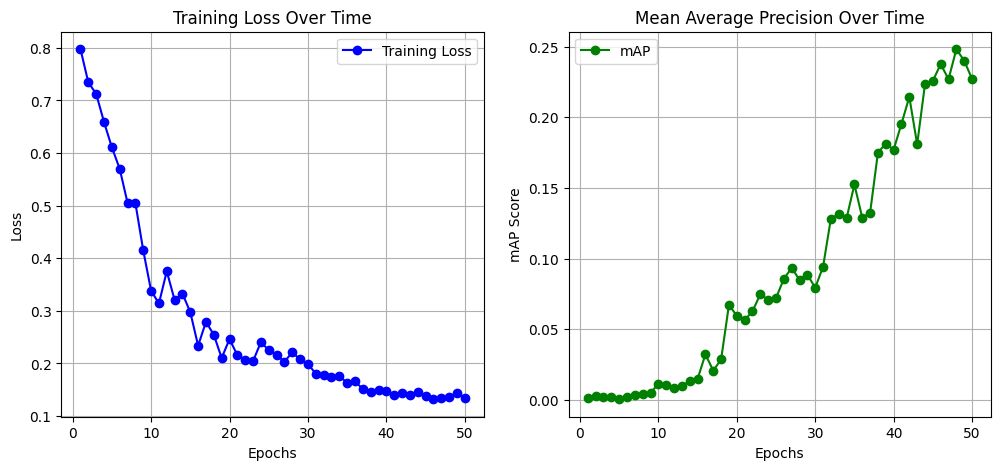

In [12]:
train(model, criterion, optimizer, trainloader, validloader)